In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [3]:
fake_df = pd.read_csv("C:/Users/kdipu/OneDrive/Desktop/Fake.csv")
real_df = pd.read_csv("C:/Users/kdipu/OneDrive/Desktop/True.csv")

In [4]:
#Checking for null values
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [6]:
#Checking for unique values for subject. We want both data frames to have a similar distribution.
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [7]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [8]:
#Drop the date from the dataset, we don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well.
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

In [9]:
#0 for fake news, and 1 for real news
fake_df['class'] = 0 
real_df['class'] = 1

Text(0, 0.5, 'Proportion of News Articles')

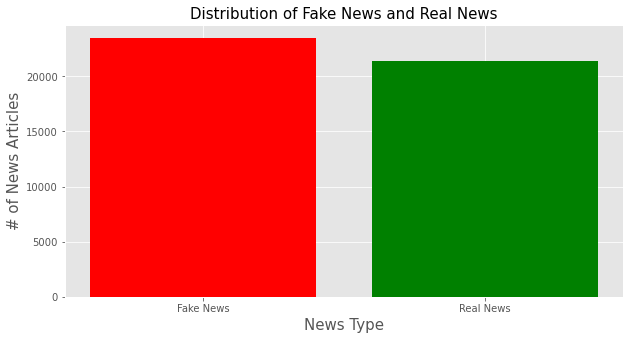

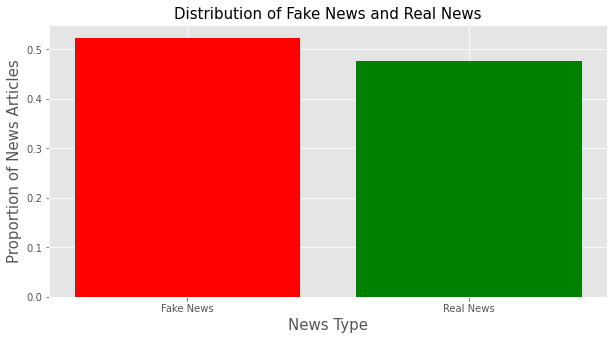

In [10]:
#Check out the distribution of fake news compare to real news
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='red')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='red')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [11]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [12]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [13]:
#Combining the title with the text, it is much easier to process this way.
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [14]:
#Split into training and testing
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [15]:
#Normalizing our data: lower case, get rid of extra spaces, and url links.
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [16]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [17]:
#Convert text to vectors, our classifier only takes numerical data.
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
#Apply padding so we have the same length for each article
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [19]:
#Building the RNN.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [20]:
#We are going to use early stop, which stops when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 298s 273ms/step - loss: 0.2256 - accuracy: 0.8932 - val_loss: 0.0483 - val_accuracy: 0.9836
Epoch 2/10
1078/1078 [==============================] - 321s 298ms/step - loss: 0.0420 - accuracy: 0.9896 - val_loss: 0.0371 - val_accuracy: 0.9855
Epoch 3/10
1078/1078 [==============================] - 2251s 2s/step - loss: 0.0223 - accuracy: 0.9943 - val_loss: 0.0312 - val_accuracy: 0.9891
Epoch 4/10
1078/1078 [==============================] - 240s 223ms/step - loss: 0.0101 - accuracy: 0.9977 - val_loss: 0.0252 - val_accuracy: 0.9922
Epoch 5/10
1078/1078 [==============================] - 270s 251ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.0311 - val_accuracy: 0.9903
Epoch 6/10
1078/1078 [==============================] - 310s 288ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0355 - val_accuracy: 0.9914


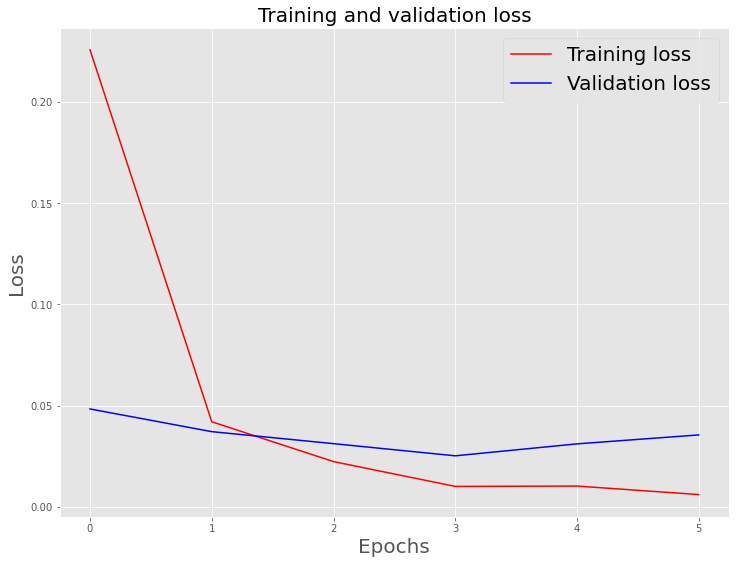

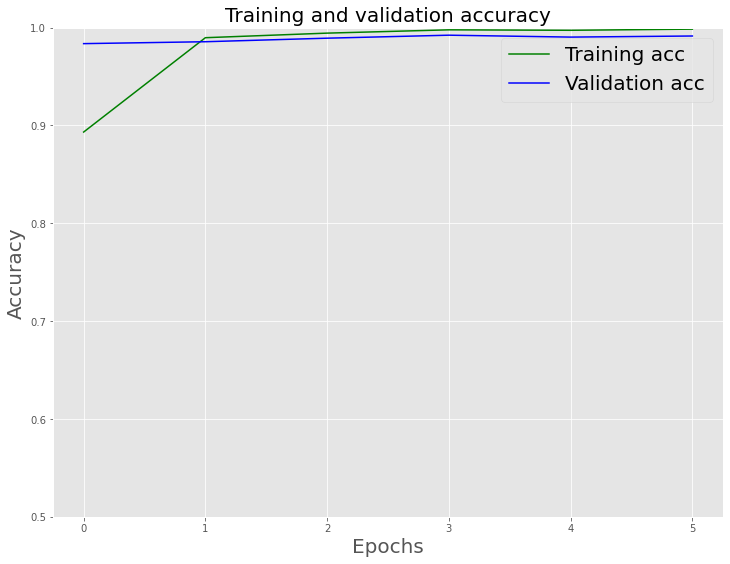

In [21]:
#Visualize our training over time
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [22]:
#Evaluate the testing set
model.evaluate(X_test, y_test)

281/281 [==============================] - 17s 61ms/step - loss: 0.0275 - accuracy: 0.9927


[0.027545848861336708, 0.9926503300666809]

In [23]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 22s 65ms/step


In [24]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9926503340757238
Precision on testing set: 0.991431218156554
Recall on testing set: 0.9932714617169374


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

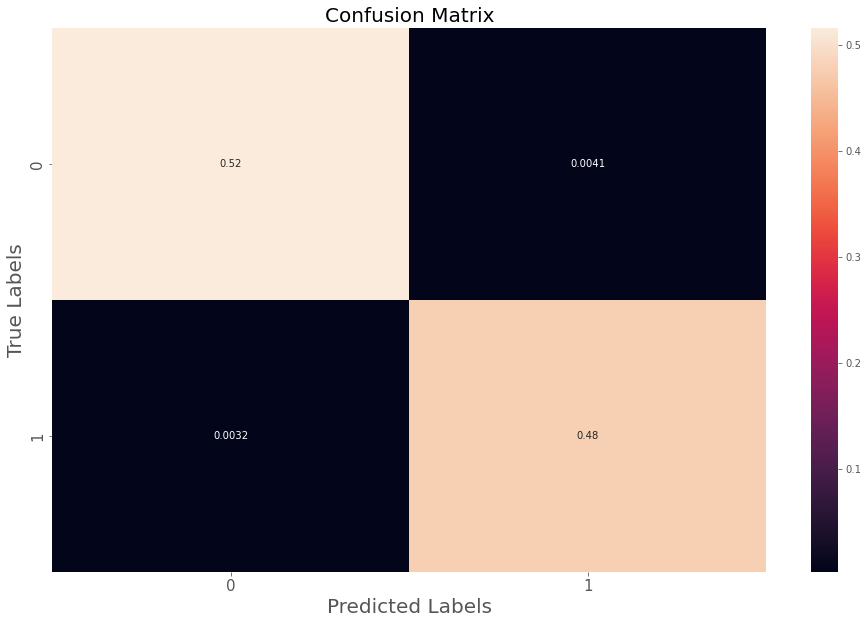

In [25]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [ ]:
# the end